In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'
register_matplotlib_converters()
sns.set(style='whitegrid',palette='muted',font_scale=1.5)
rcParams['figure.figsize']=22,10


tf.random.set_seed(42)

In [2]:
data_by_month=pd.read_excel("DatabyMonth-135-8years.xlsx")

In [3]:
index=pd.date_range(start='2011',end='2019',freq='M',name='Date')
data_by_month.index=index
data_by_month.head()

,Truck
Date,
2011-01-31,39
2011-02-28,41
2011-03-31,57
2011-04-30,61
2011-05-31,54


In [4]:
data_by_month['month']=data_by_month.index.month
data_by_month['quarter']=data_by_month.index.quarter

<AxesSubplot:xlabel='Date', ylabel='Truck'>

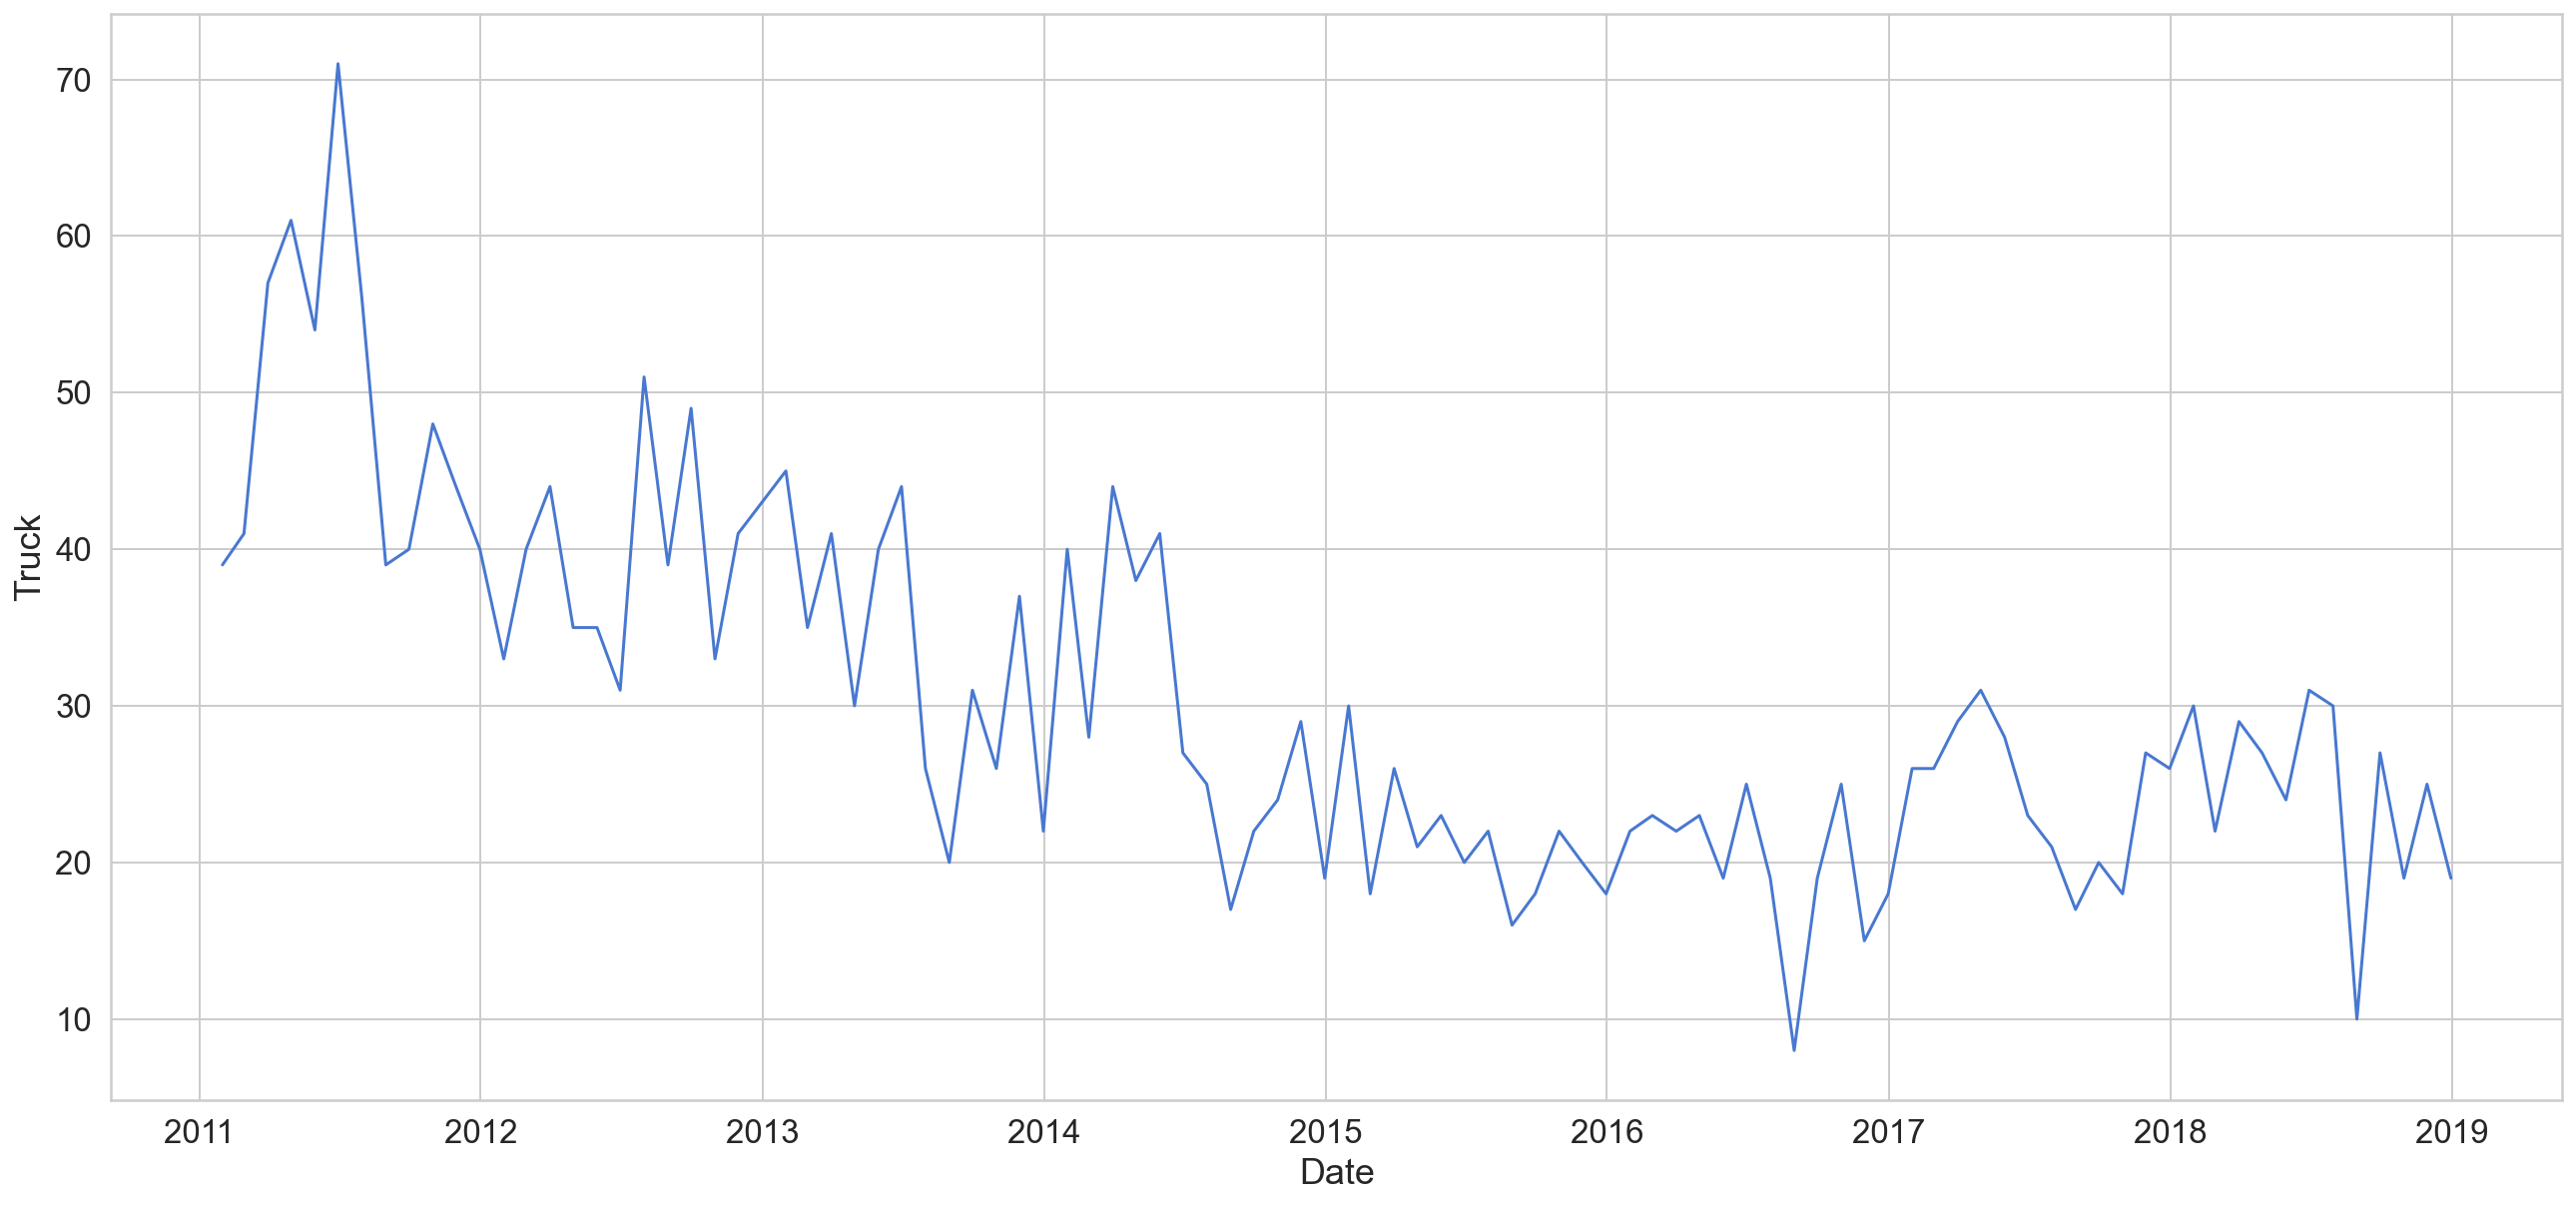

In [5]:
sns.lineplot(x=data_by_month.index,y='Truck',data=data_by_month)

<AxesSubplot:xlabel='Date', ylabel='Truck'>

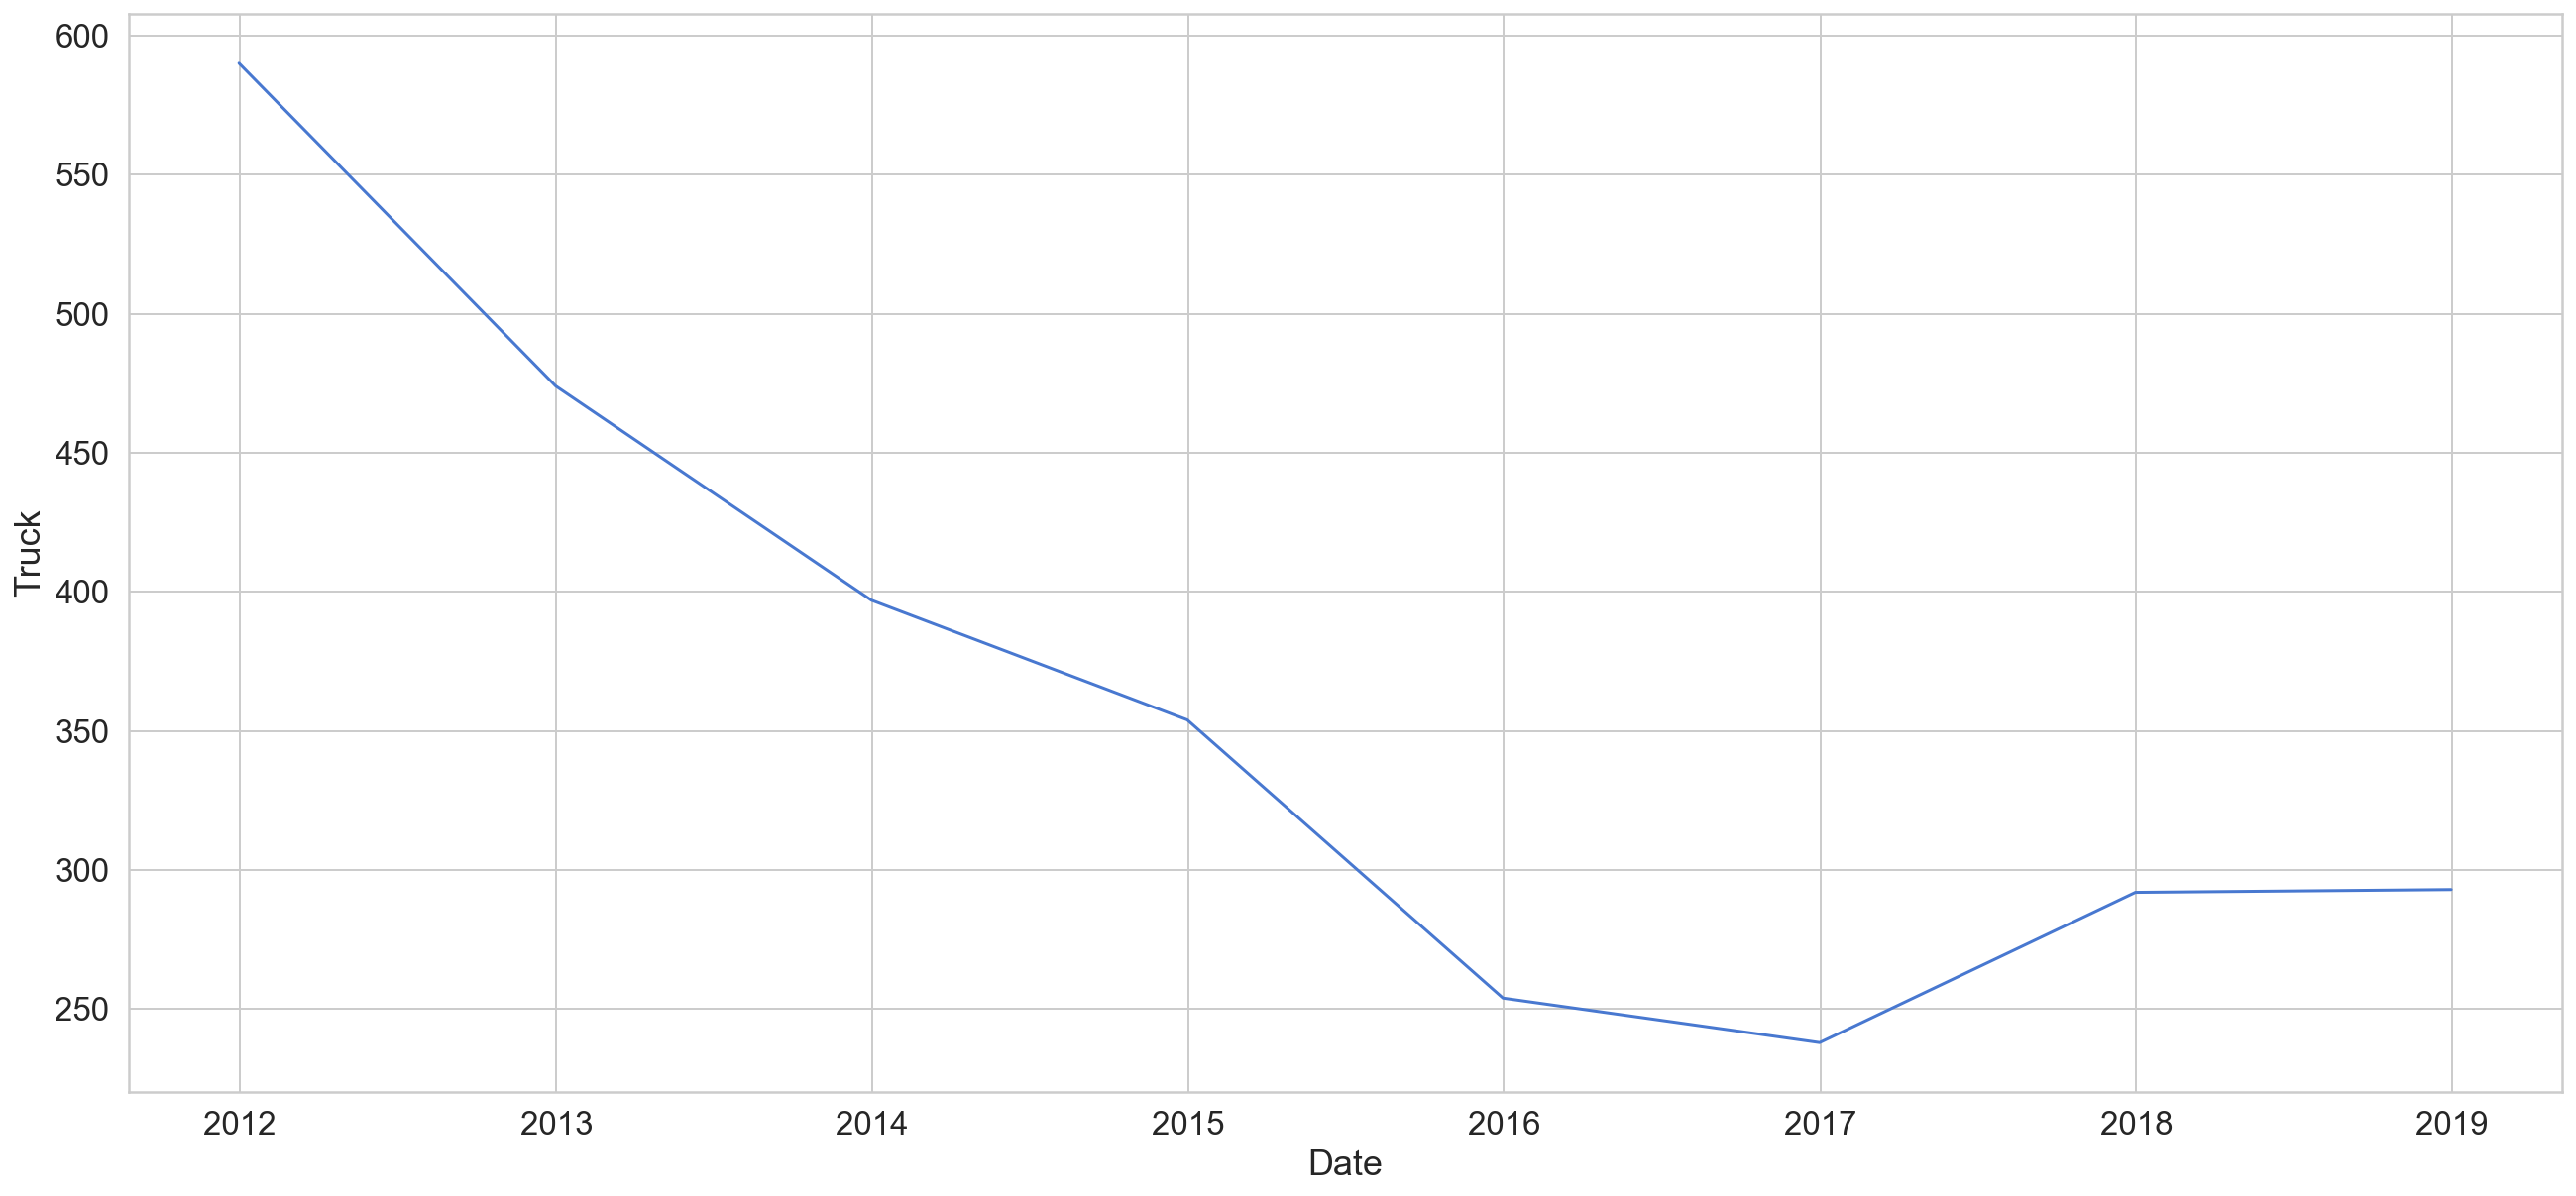

In [6]:
data_by_year=data_by_month.resample('Y').sum()
sns.lineplot(x=data_by_year.index,y='Truck',data=data_by_year)

<AxesSubplot:xlabel='month', ylabel='Truck'>

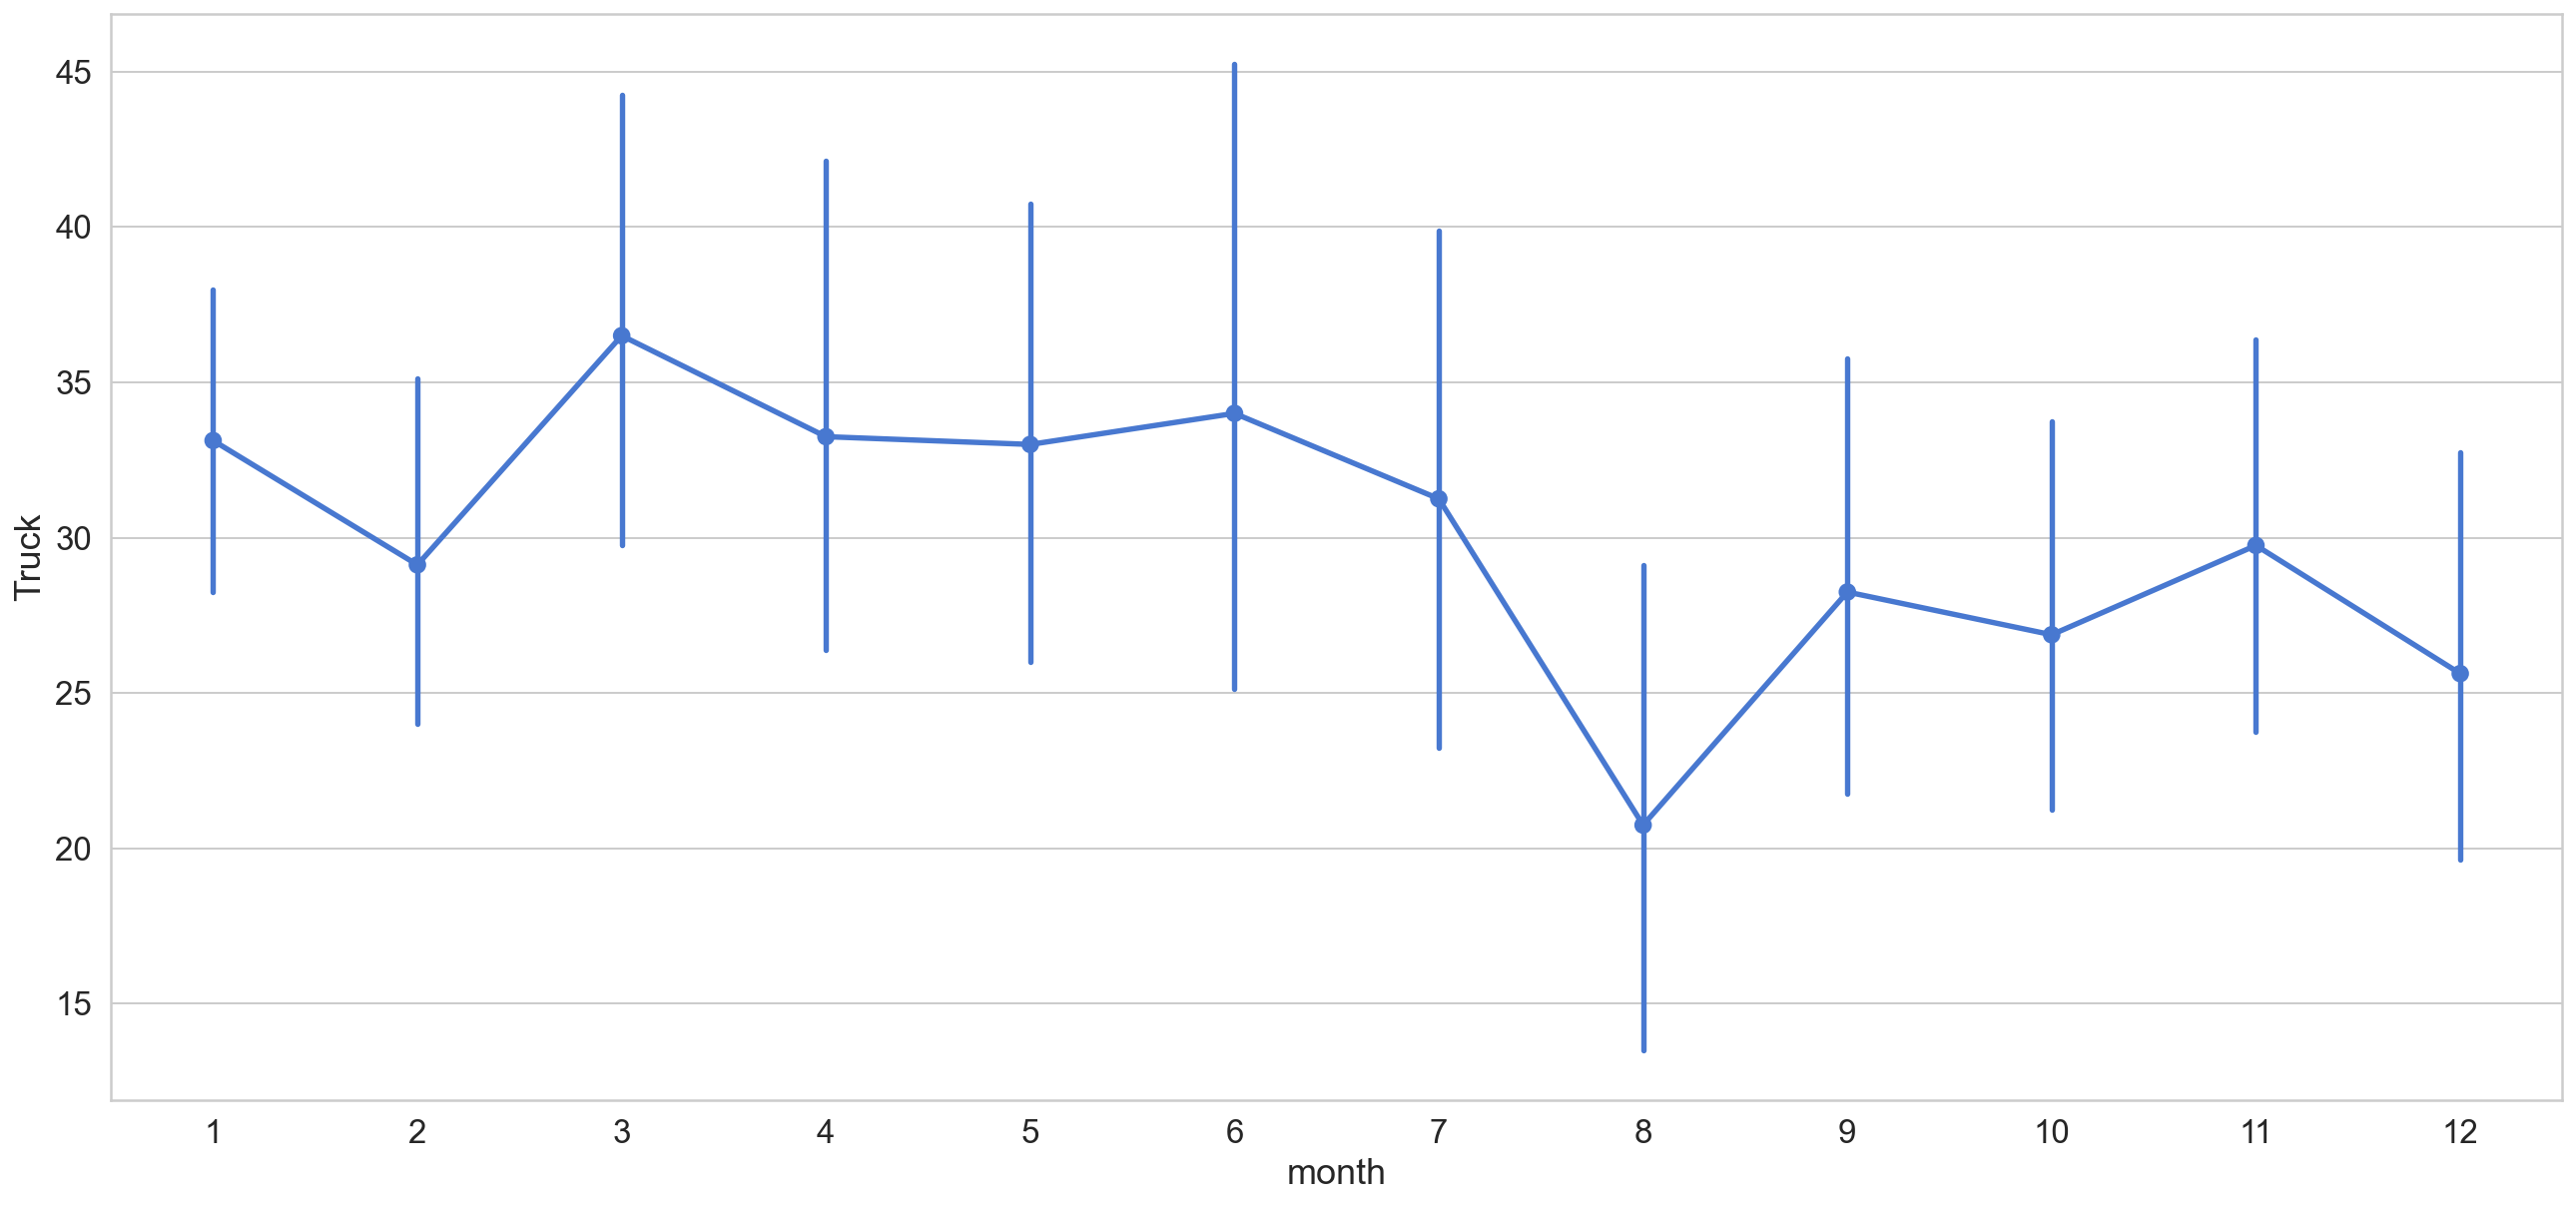

In [7]:
sns.pointplot(data=data_by_month,x='month',y='Truck')

In [8]:
train_size = int(len(data_by_month) * 0.85)
test_size = len(data_by_month) - train_size
train, test = data_by_month.iloc[0:train_size], data_by_month.iloc[train_size:len(data_by_month)]
print(train.shape,test.shape)

(81, 3) (15, 3)


In [9]:
from sklearn.preprocessing import RobustScaler,MinMaxScaler

In [10]:
scaler = RobustScaler()
scaler.fit(train['Truck'].values.reshape(-1,1))
train['Truck']= scaler.transform(train['Truck'].values.reshape(-1,1))
test['Truck']= scaler.transform(test['Truck'].values.reshape(-1,1))

<ipython-input-10-4e315a9d601b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Truck']= scaler.transform(train['Truck'].values.reshape(-1,1))
<ipython-input-10-4e315a9d601b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Truck']= scaler.transform(test['Truck'].values.reshape(-1,1))


In [11]:
test

,Truck,month,quarter
Date,,,
2017-10-31,-0.555556,10,4
2017-11-30,-0.055556,11,4
2017-12-31,-0.111111,12,4
2018-01-31,0.111111,1,1
2018-02-28,-0.333333,2,1
2018-03-31,0.055556,3,1
2018-04-30,-0.055556,4,2
2018-05-31,-0.222222,5,2
2018-06-30,0.166667,6,2


In [12]:
def create_dataset(X, y, time_steps=0):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [13]:
time_steps = 2
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.Truck, time_steps)
X_test, y_test = create_dataset(test, test.Truck, time_steps)
print(X_train.shape, y_train.shape)

(79, 2, 3) (79,)


In [14]:
model = keras.Sequential()
model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=128,input_shape=(X_train.shape[1], X_train.shape[2]))))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [15]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=10,
    validation_split=0.1,
    shuffle=False)

Epoch 1/30
8/8 [==============================] - 1s 111ms/step - loss: 0.6805 - val_loss: 0.1864
Epoch 2/30
8/8 [==============================] - 0s 6ms/step - loss: 0.3583 - val_loss: 0.0458
Epoch 3/30
8/8 [==============================] - 0s 6ms/step - loss: 0.4987 - val_loss: 0.1059
Epoch 4/30
8/8 [==============================] - 0s 6ms/step - loss: 0.4039 - val_loss: 0.1832
Epoch 5/30
8/8 [==============================] - 0s 6ms/step - loss: 0.3380 - val_loss: 0.1433
Epoch 6/30
8/8 [==============================] - 0s 5ms/step - loss: 0.2550 - val_loss: 0.0734
Epoch 7/30
8/8 [==============================] - 0s 6ms/step - loss: 0.2787 - val_loss: 0.0880
Epoch 8/30
8/8 [==============================] - 0s 5ms/step - loss: 0.2789 - val_loss: 0.1099
Epoch 9/30
8/8 [==============================] - 0s 6ms/step - loss: 0.2451 - val_loss: 0.1089
Epoch 10/30
8/8 [==============================] - 0s 6ms/step - loss: 0.2213 - val_loss: 0.0934
Epoch 11/30
8/8 [====================

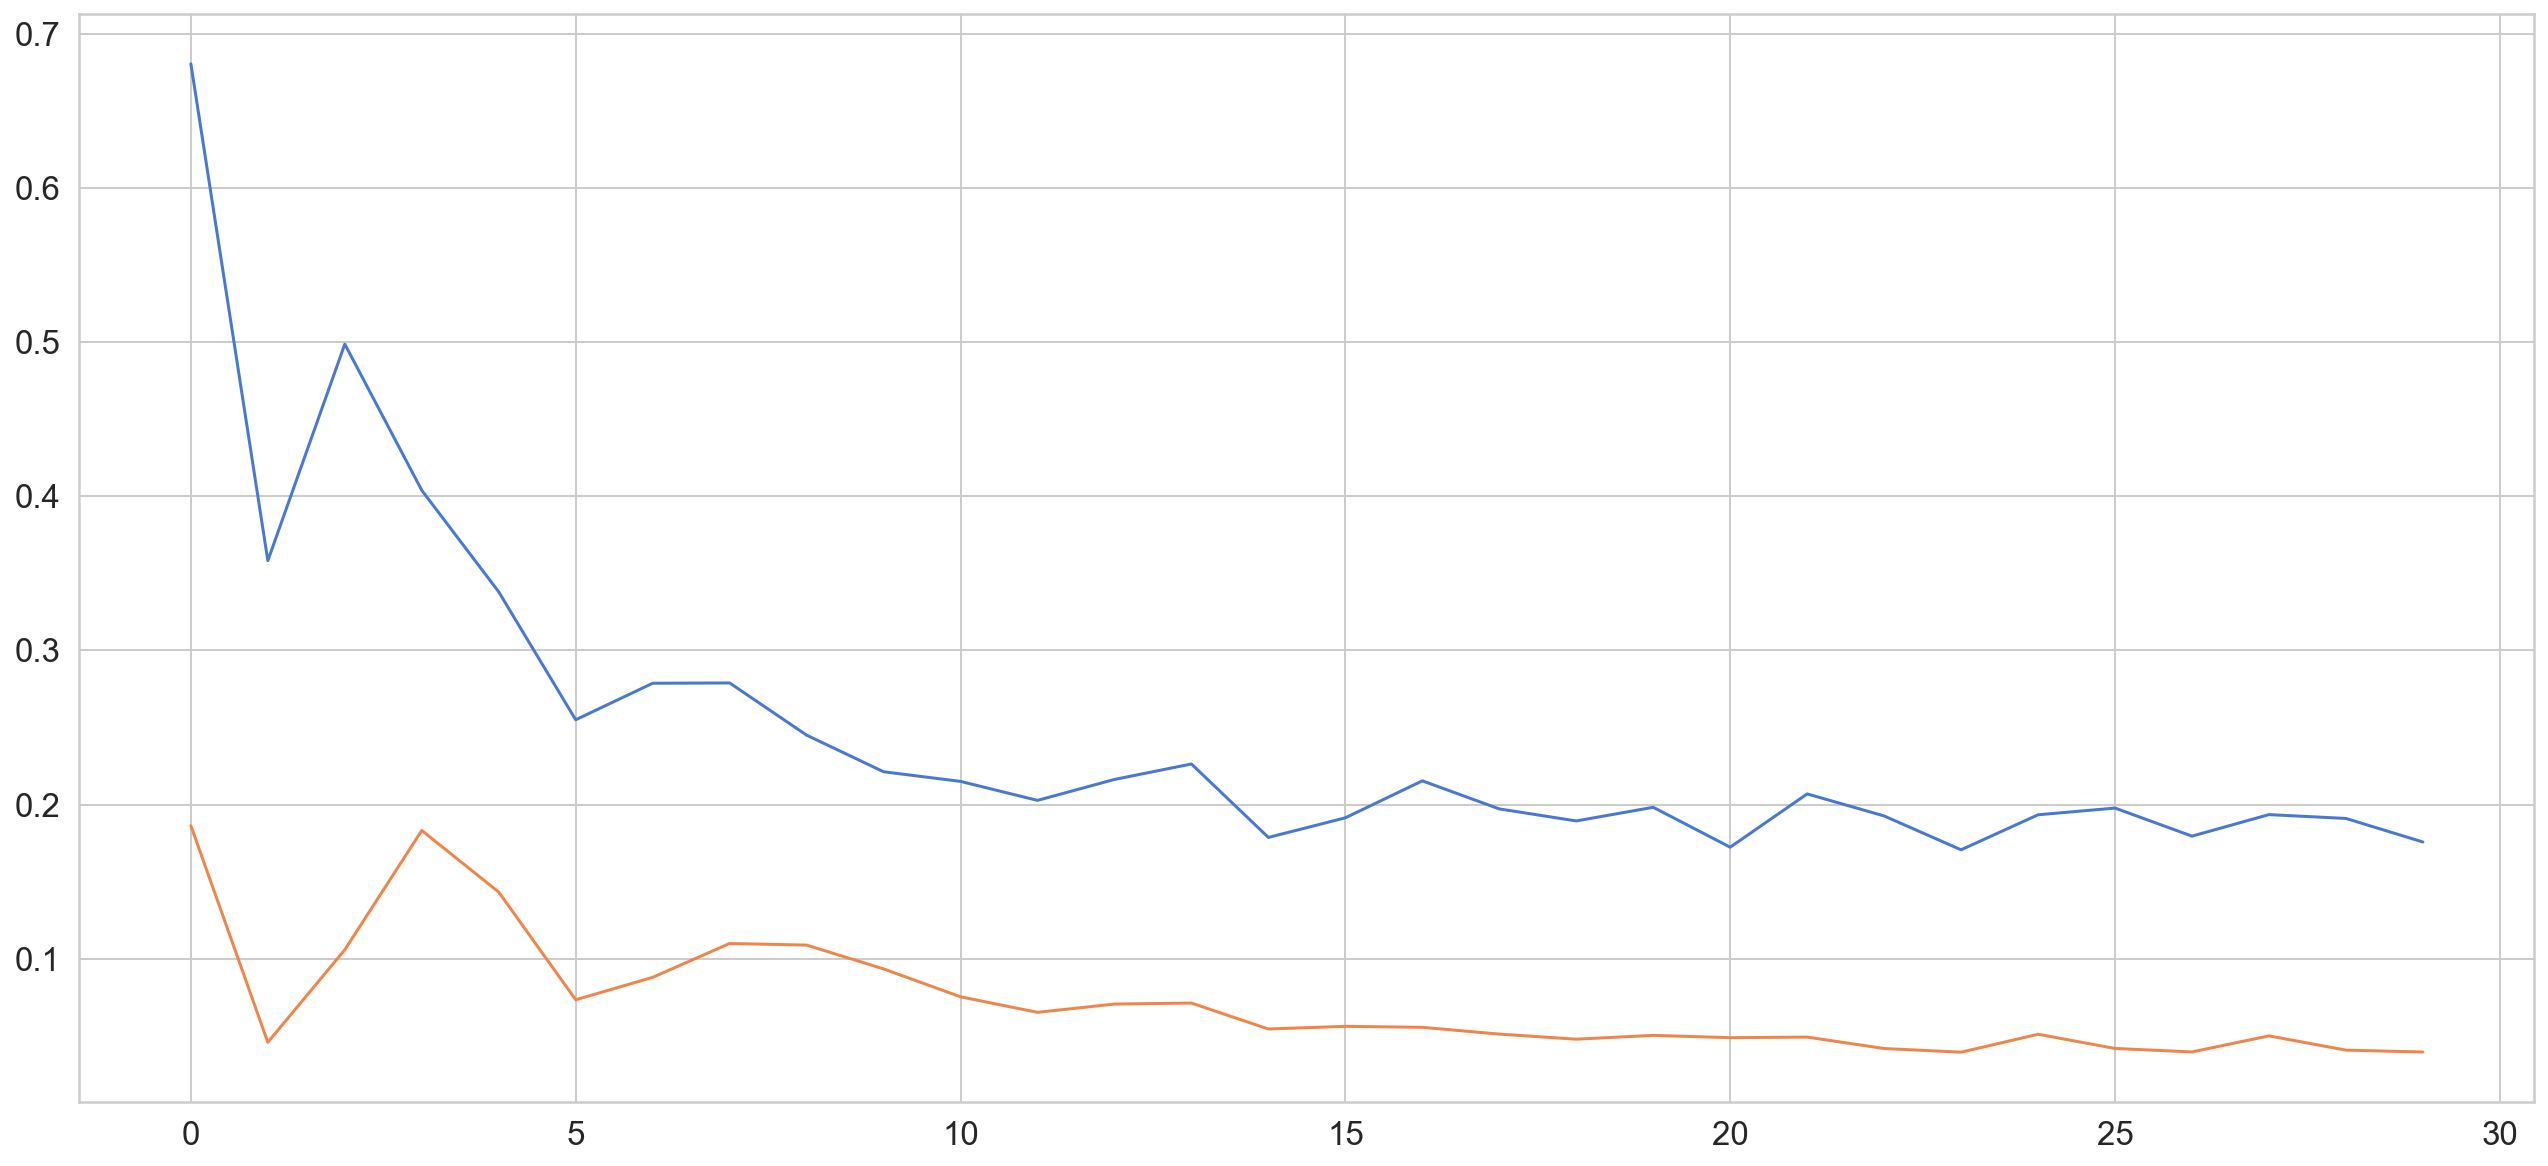

In [16]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')

In [17]:
y_pred=model.predict(X_test)

In [18]:
y_pred

array([[-0.12736978],
       [ 0.08919992],
       [-0.16028054],
       [-0.02281097],
       [-0.09986668],
       [-0.06035871],
       [-0.17474987],
       [-0.08088439],
       [ 0.01036213],
       [-0.3840471 ],
       [-0.3779903 ],
       [-0.20536588],
       [-0.14670725]], dtype=float32)

In [19]:
y_train_inv = scaler.inverse_transform(y_train.reshape(1, -1))
y_test_inv = scaler.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = scaler.inverse_transform(y_pred)

In [20]:
y_pred_inv

array([[25.707344],
       [29.605598],
       [25.11495 ],
       [27.589403],
       [26.2024  ],
       [26.913544],
       [24.854502],
       [26.54408 ],
       [28.186518],
       [21.087152],
       [21.196175],
       [24.303413],
       [25.35927 ]], dtype=float32)

In [26]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [22]:
mean_absolute_error(y_test_inv.flatten(),y_pred_inv.flatten())

3.9905047783484826

In [28]:
np.sqrt(mean_squared_error(y_test_inv.flatten(),y_pred_inv.flatten()))

6.090530177452991

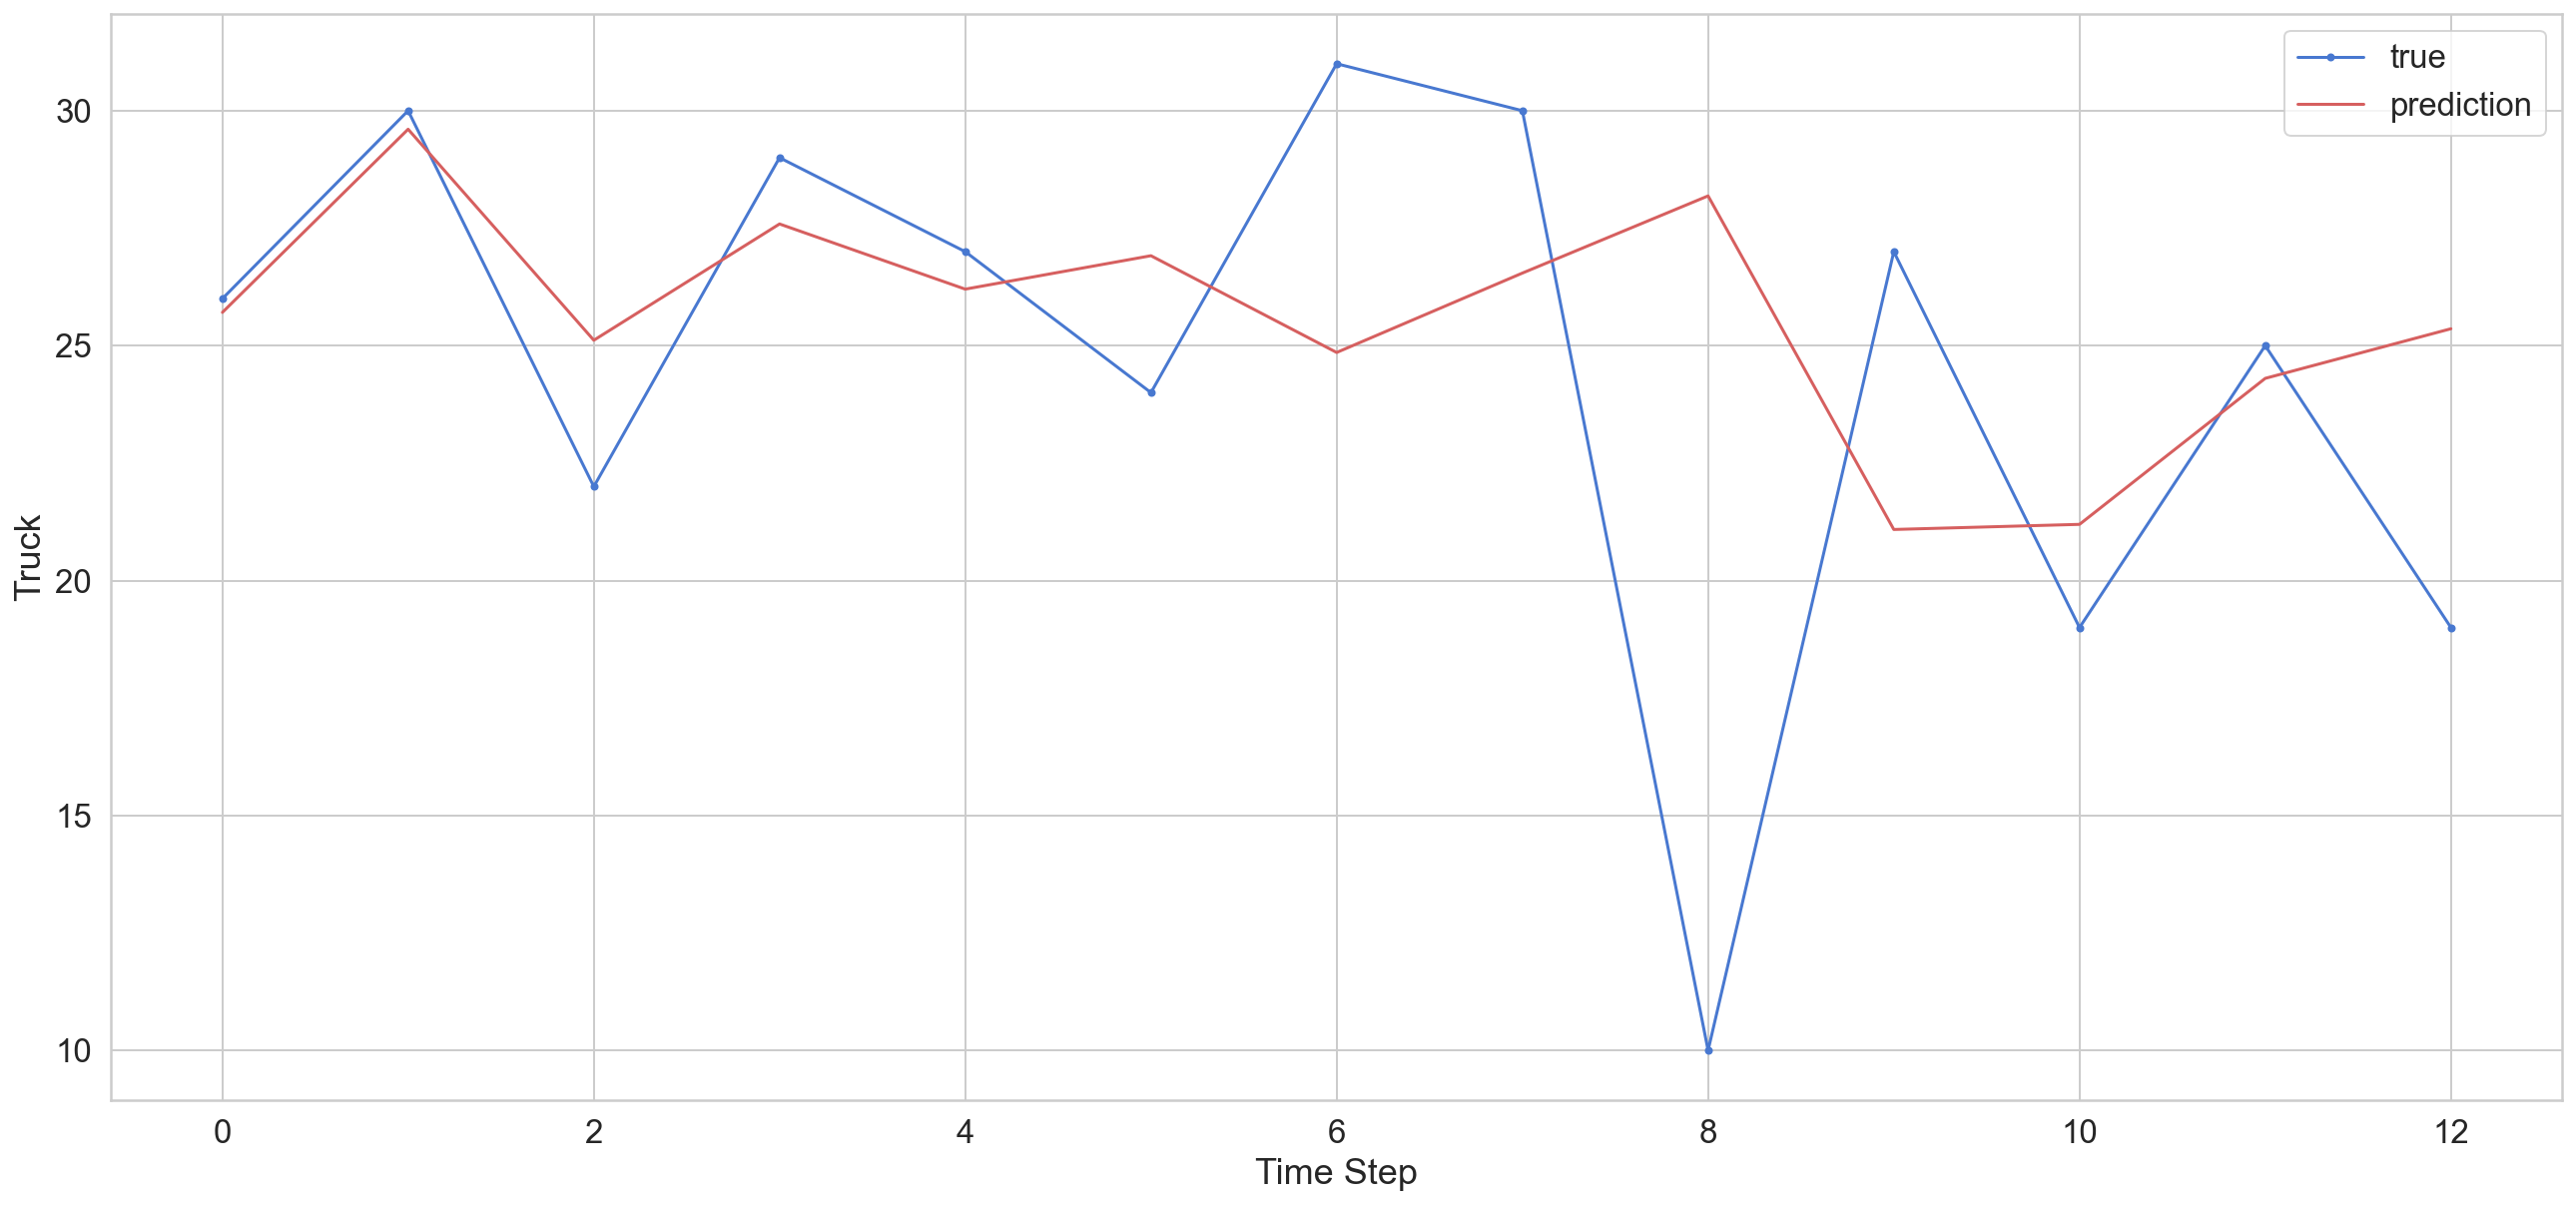

In [24]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Truck')
plt.xlabel('Time Step')
plt.legend()
plt.show();

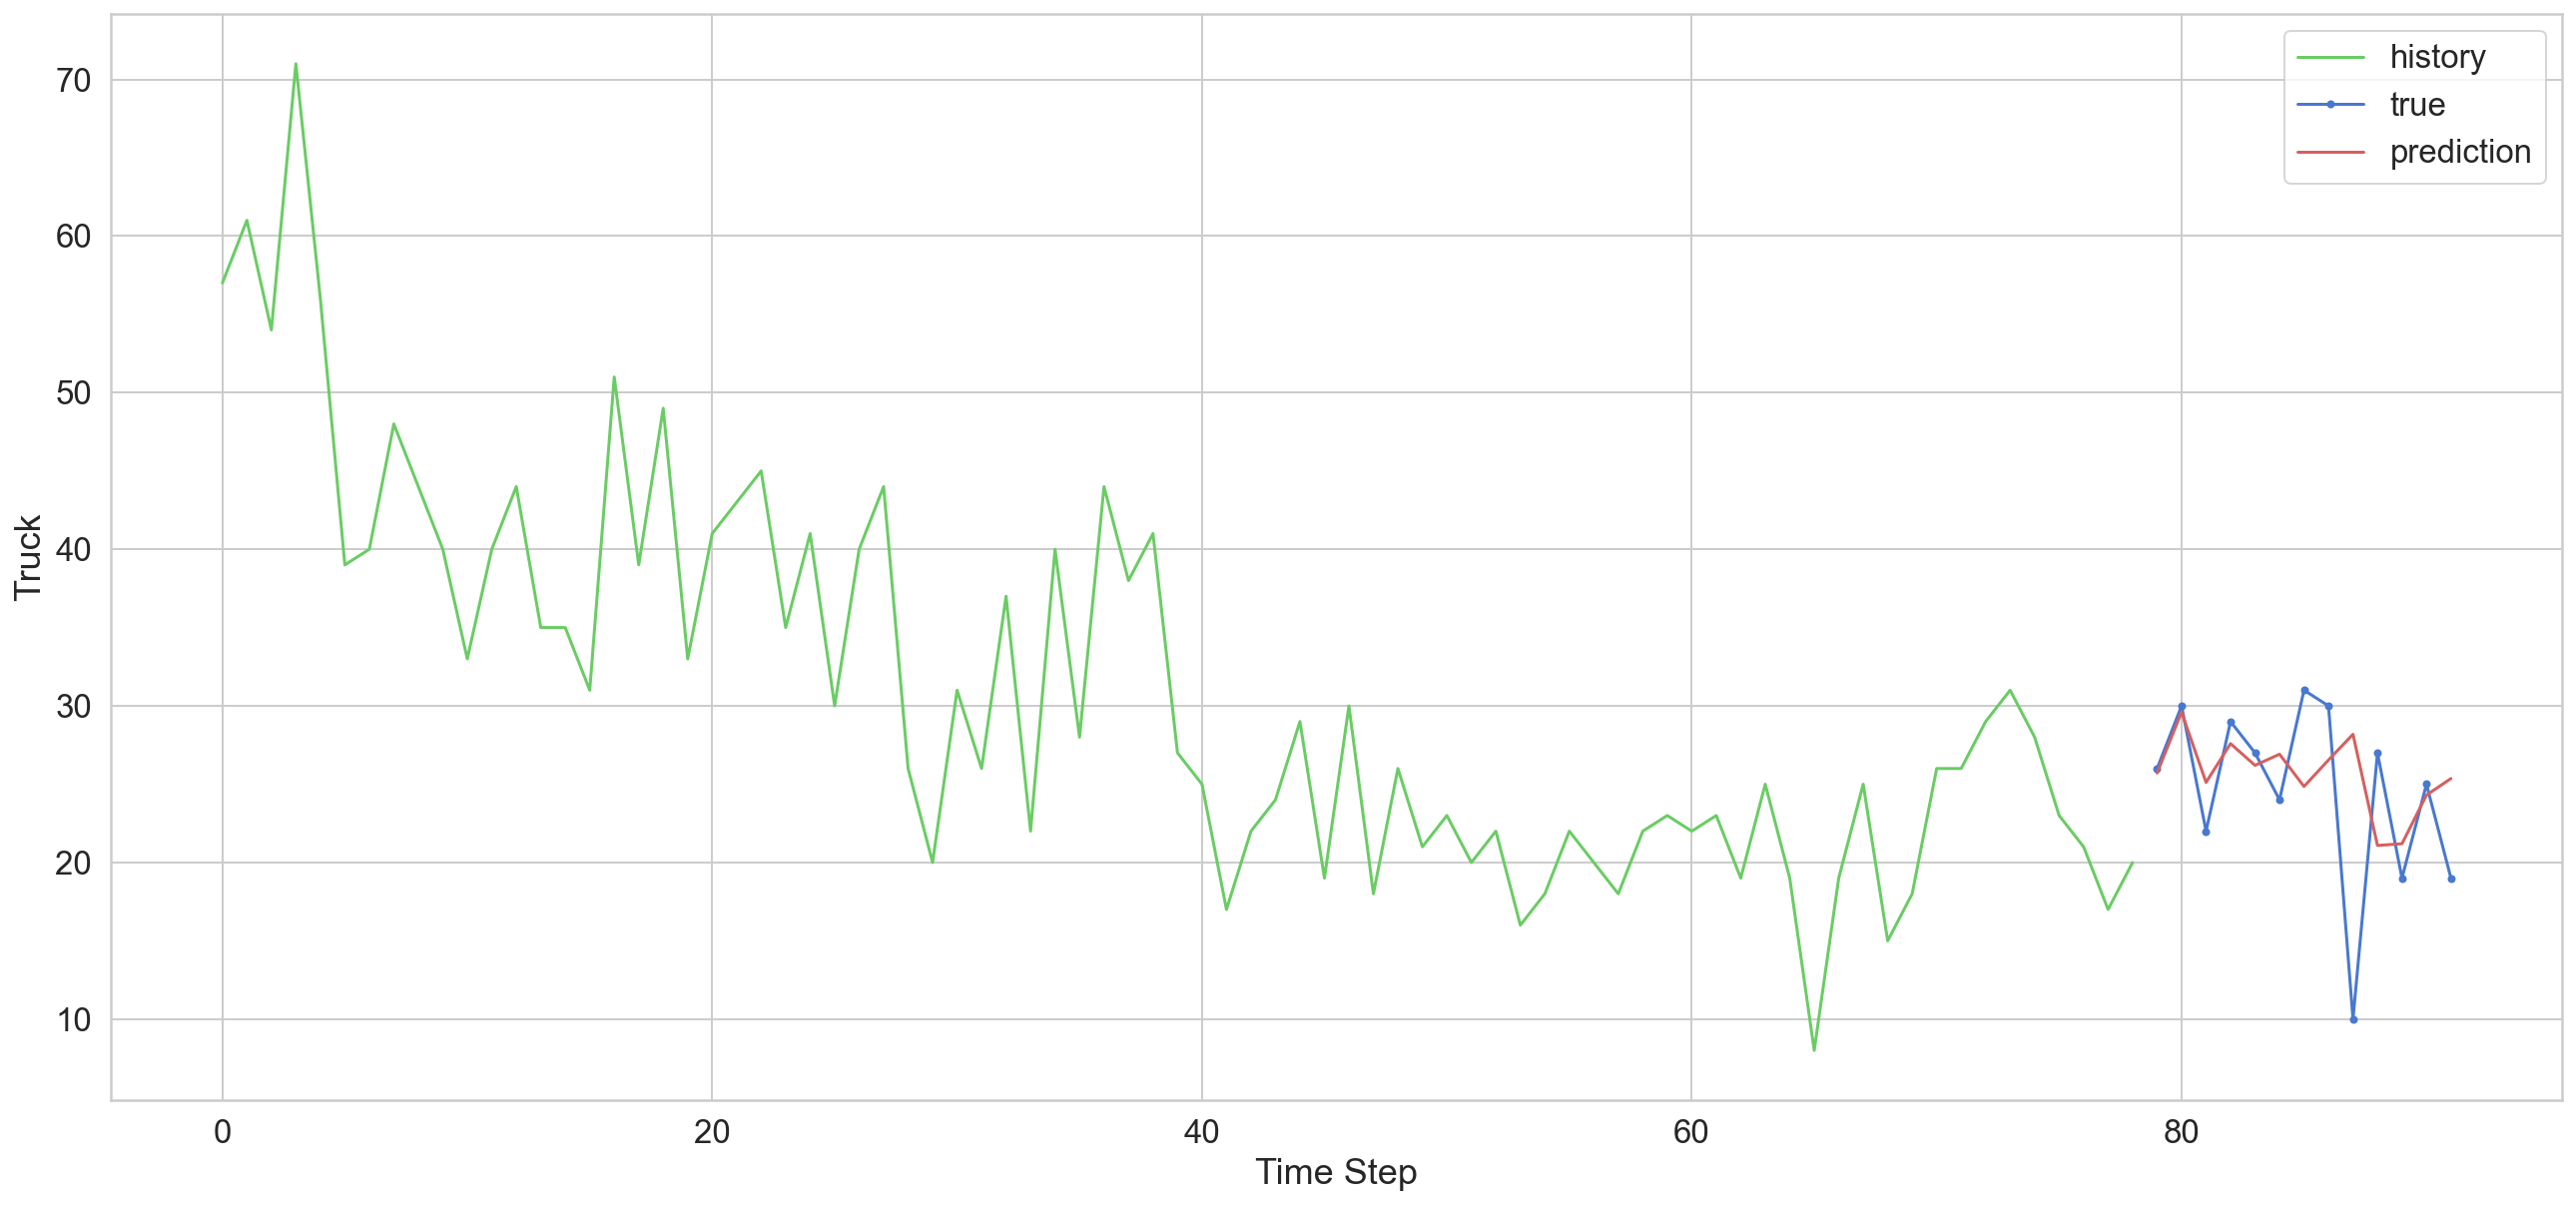

In [25]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Truck')
plt.xlabel('Time Step')
plt.legend()
plt.show();